In [1]:
import os
from tensorflow import keras
from tensorflow.keras  import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Lambda, MaxPooling2D, Dropout, Layer
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from absl import app
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [2]:
import tensorflow_datasets as tfds
tf.compat.v1.disable_eager_execution()

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
init = keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=None)

In [5]:
model_dir = "MNIST_data/"
n_concept = 5
n_cluster = 5
n = 60000
batch_size = 128
pretrain = False
verbose = 2
thres = 0.2

In [20]:
train = pd.read_csv("../data/MNIST/mnist_train.csv")
test = pd.read_csv("../data/MNIST/mnist_test.csv")

y_train = np.asarray(train["label"])
y_test = np.asarray(test["label"])
# Drop 'label' column
x_train = train.drop(labels = ["label"],axis = 1) 
x_train = x_train.values.reshape(-1,28,28,1)
x_test = test.drop(labels = ["label"],axis = 1) 
x_test = x_test.values.reshape(-1,28,28,1)
y_val = y_test

In [7]:
def load_model_stm_new(dataset, x_val, y_val, width=28, 
                       height=28, channel=1, pretrain=True, verbose=True):
    """Loads pretrain model or train one."""
    input1 = Input(
      shape=(
          width,
          height,
          channel,
      ), name='concat_input')
    conv1 = Conv2D(32, kernel_size=5, activation='relu', padding='same')
    conv2 = Conv2D(32, kernel_size=5, activation='relu', padding='same')
    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='same')
    conv4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')
    dense1 = Dense(256, activation='relu')
    predict = Dense(10, activation='softmax')

    conv1o = conv1(input1)
    conv2o = conv2(conv1o)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2o)
    drop1  = Dropout(.25)(pool1)
    conv3o = conv3(drop1)
    conv4o = conv4(conv3o)
    pool2 = MaxPooling2D(pool_size=(2, 2),  strides=(2,2))(conv4o)
    drop2  = Dropout(.25)(pool2)
    drop2f = Flatten()(drop2)
    fc1 = dense1(drop2f)
    softmax1 = predict(fc1)

    drop2_2 = Input(shape=(7,7,64), name='concat_input')  
    drop2f_2 = Flatten()(drop2_2)
    fc1_2 = dense1(drop2f_2)
    softmax1_2 = predict(fc1_2)

    mlp = Model(input1, softmax1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    mlp.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy'])

    if pretrain:
        mlp.load_weights(model_dir+'conv_toy.h5')
    else:
        _ = mlp.fit(dataset,epochs=10,verbose=verbose)
        mlp.save_weights(model_dir+'conv_toy.h5')

    for layer in mlp.layers:
        layer.trainable = False

    feature_model = Model(input1, drop2)
    predict_model  = Model(drop2_2, softmax1_2)

    return feature_model, predict_model

In [8]:
def new_training_set(seed,percentage):
    np.random.seed(seed)
    indices = np.random.choice(len(x_train), size=int(percentage*len(x_train)), replace=False)
    ds_train = tf.data.Dataset.from_tensor_slices((x_train[indices], y_train[indices]))
    ds_train = ds_train.map(
        normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(len(x_train))
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
    return ds_train, indices

In [9]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [10]:
ds_train_small,ind  = new_training_set(0,0.7)

In [11]:
feature_model, predict_model = load_model_stm_new(ds_train_small, x_test, y_test, pretrain=pretrain,verbose=verbose)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 329 steps
Epoch 1/10
329/329 - 6s - loss: 0.2192 - accuracy: 0.9303
Epoch 2/10
329/329 - 5s - loss: 0.0586 - accuracy: 0.9821
Epoch 3/10
329/329 - 4s - loss: 0.0412 - accuracy: 0.9878
Epoch 4/10
329/329 - 5s - loss: 0.0320 - accuracy: 0.9902
Epoch 5/10
329/329 - 4s - loss: 0.0266 - accuracy: 0.9920
Epoch 6/10
329/329 - 5s - loss: 0.0222 - accuracy: 0.9930
Epoch 7/10
329/329 - 5s - loss: 0.0211 - accuracy: 0.9938
Epoch 8/10
329/329 - 4s - loss: 0.0181 - accuracy: 0.9950
Epoch 9/10
329/329 - 4s - loss: 0.0172 - accuracy: 0.9951
Epoch 10/10
329/329 - 4s - loss: 0.0154 - accuracy: 0.9955


In [12]:
f_train = feature_model.predict(x_train[ind])
f_val = feature_model.predict(x_test)
print(f_train.shape)
N = f_train.shape[0]
trained = False

(42000, 7, 7, 64)


In [13]:
class Weight(Layer):
    """Simple Weight class."""

    def __init__(self, dim, **kwargs):
        self.dim = dim
        super(Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        # creates a trainable weight variable for this layer.
        self.kernel = self.add_weight(
            name='proj', shape=self.dim, initializer=init, trainable=True)
        super(Weight, self).build(input_shape)

    def call(self, x):
        return self.kernel

    def compute_output_shape(self, input_shape):
        return self.dim

In [14]:
def mean_sim(topic_prob_n,n_concept):
  """creates loss for topic model"""
  def loss(y_true, y_pred):
    return 1*tf.reduce_mean(input_tensor=tf.nn.top_k(K.transpose(K.reshape(topic_prob_n,(-1,n_concept))),k=32,sorted=True).values)
  return loss

In [15]:
def topic_model_new_MNIST(predict,
           f_train,
           y_train,
           n_concept,
           verbose=False,
           metric1=['accuracy'],
           opt='adam',
           loss1=tf.nn.softmax_cross_entropy_with_logits,
           thres=0.0,
           load=False):
    """Returns main function of topic model."""


    f_input = Input(shape=(f_train.shape[1],f_train.shape[2],f_train.shape[3]), name='f_input')
    f_input_n =  Lambda(lambda x:K.l2_normalize(x,axis=(3)))(f_input)

    topic_vector = Weight((f_train.shape[3], n_concept))(f_input)
    topic_vector_n = Lambda(lambda x: K.l2_normalize(x, axis=0))(topic_vector)
    topic_prob = Lambda(lambda x:K.dot(x[0],x[1]))([f_input, topic_vector_n])
    topic_prob_n = Lambda(lambda x:K.dot(x[0],x[1]))([f_input_n, topic_vector_n])
    topic_prob_mask = Lambda(lambda x:K.cast(K.greater(x,thres),'float32'))(topic_prob_n)
    topic_prob_am = Lambda(lambda x:x[0]*x[1])([topic_prob,topic_prob_mask])
    topic_prob_sum = Lambda(lambda x: K.sum(x, axis=3, keepdims=True)+1e-3)(topic_prob_am)
    topic_prob_nn = Lambda(lambda x: x[0]/x[1])([topic_prob_am, topic_prob_sum])

    rec_vector_1 = Weight((n_concept, 500))(f_input)
    rec_vector_2 = Weight((500, f_train.shape[3]))(f_input)
    rec_layer_1 = Lambda(lambda x:K.relu(K.dot(x[0],x[1])))([topic_prob_nn, rec_vector_1])
    rec_layer_2 = Lambda(lambda x:K.dot(x[0],x[1]))([rec_layer_1, rec_vector_2])
    pred = predict(rec_layer_2)
    topic_model_pr = Model(inputs=f_input, outputs=pred)
    topic_model_pr.layers[-1].trainable = False
    if opt =='sgd':
        optimizer = SGD(lr=0.001)
        optimizer_state = [optimizer.iterations, optimizer.lr,
              optimizer.momentum, optimizer.decay]
        optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
    elif opt =='adam':
        optimizer = Adam(lr=0.001)
        optimizer_state = [optimizer.iterations, optimizer.lr, optimizer.beta_1,
                                 optimizer.beta_2, optimizer.decay]
        optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
    metric1.append(mean_sim(topic_prob_n, n_concept))
    topic_model_pr.compile(
      loss=topic_loss_MNIST(topic_prob_n, topic_vector_n,  n_concept, f_input, loss1=loss1),
      optimizer=optimizer,metrics=metric1)
    print(topic_model_pr.summary())
    if load:
        topic_model_pr.load_weights(load)
    return topic_model_pr, optimizer_reset, optimizer, topic_vector_n,  n_concept, f_input

In [16]:
def topic_loss_MNIST(topic_prob_n, topic_vector_n, n_concept, f_input, loss1):
  """creates loss for topic model"""
  def loss(y_true, y_pred):
    return (1.0*tf.reduce_mean(input_tensor=loss1(y_true, y_pred))\
            - 0.1*tf.reduce_mean(input_tensor=(tf.nn.top_k(K.transpose(K.reshape(topic_prob_n,(-1,n_concept))),k=32,sorted=True).values))
            + 0.1*tf.reduce_mean(input_tensor=(K.dot(K.transpose(topic_vector_n), topic_vector_n) - np.eye(n_concept)))
            )
  return loss

In [17]:
topic_model_pr, optimizer_reset, optimizer, \
  topic_vector,  n_concept, f_input = topic_model_new_MNIST(predict_model,
                                f_train,
                                y_train,
                                n_concept,
                                verbose=verbose,
                                metric1=['accuracy'],
                                loss1=tf.keras.losses.sparse_categorical_crossentropy,
                                thres=0.2,
                                load=False)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
f_input (InputLayer)            [(None, 7, 7, 64)]   0                                            
__________________________________________________________________________________________________
weight (Weight)                 (64, 5)              320         f_input[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (64, 5)              0           weight[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7, 7, 64)     0           f_input[0][0]                    
____________________________________________________________________________________________

In [19]:
topic_model_pr.fit(
  f_train,
  y_train[ind],
  batch_size=batch_size,
  epochs=10,   validation_data=(f_val, y_val),
  verbose=verbose)

Train on 42000 samples, validate on 10000 samples
Epoch 1/10
42000/42000 - 3s - loss: 0.9805 - accuracy: 0.0958 - loss_1: 0.3435 - val_loss: 0.2591 - val_accuracy: 0.1001 - val_loss_1: 0.3796
Epoch 2/10
42000/42000 - 3s - loss: 0.1912 - accuracy: 0.0996 - loss_1: 0.4184 - val_loss: 0.1041 - val_accuracy: 0.0978 - val_loss_1: 0.4572
Epoch 3/10
42000/42000 - 3s - loss: 0.0962 - accuracy: 0.0997 - loss_1: 0.4972 - val_loss: 0.0509 - val_accuracy: 0.0976 - val_loss_1: 0.5345
Epoch 4/10
42000/42000 - 3s - loss: 0.0558 - accuracy: 0.0993 - loss_1: 0.5699 - val_loss: 0.0329 - val_accuracy: 0.0955 - val_loss_1: 0.6004
Epoch 5/10
42000/42000 - 3s - loss: 0.0268 - accuracy: 0.0992 - loss_1: 0.6261 - val_loss: 0.0187 - val_accuracy: 0.0992 - val_loss_1: 0.6471
Epoch 6/10
42000/42000 - 3s - loss: 0.0136 - accuracy: 0.0994 - loss_1: 0.6685 - val_loss: 0.0124 - val_accuracy: 0.0985 - val_loss_1: 0.6855
Epoch 7/10
42000/42000 - 3s - loss: 0.0082 - accuracy: 0.0996 - loss_1: 0.7006 - val_loss: 0.0034 

In [20]:
predict = topic_model_pr.predict(f_train)

In [22]:
topic_model_pr.evaluate(f_train,y_train[ind])

42000/42000 [==============================] - 6s 146us/sample - loss: -0.0082 - accuracy: 0.1007 - loss_1: 0.6625


[-0.008222715251502536, 0.100666665, 0.6624555]

In [23]:
(np.argmax(predict,axis=1) == y_train[ind]).mean()

0.979047619047619

In [24]:
topic_model_pr.save_weights(model_dir+'latest_topic_toy.h5')

topic_vec = topic_model_pr.layers[1].get_weights()[0]
recov_vec = topic_model_pr.layers[-3].get_weights()[0]
topic_vec_n = topic_vec/(np.linalg.norm(topic_vec,axis=0,keepdims=True)+1e-9)

In [25]:
f_train_n = f_train/(np.linalg.norm(f_train,axis=3,keepdims=True)+1e-9)
topic_vec_n = topic_vec/(np.linalg.norm(topic_vec,axis=0,keepdims=True)+1e-9)
topic_prob = np.matmul(f_train_n,topic_vec_n)
n_size = 7
j_int, a, b = {},{},{}
for i in range(n_concept):
    j_int[i], a[i], b[i] = [], [], []
    ind = np.argpartition(topic_prob[:,:,:,i].flatten(), -10)[-10:]
    sim_list = topic_prob[:,:,:,i].flatten()[ind]
    for jc,j in enumerate(ind):
        j_int[i].append(int(np.floor(j/(n_size*n_size))))
        a[i].append(int((j-j_int[i][-1]*(n_size*n_size))/n_size))
        b[i].append(int((j-j_int[i][-1]*(n_size*n_size))%n_size))
        #MNIST_helper.copy_save_image(x_train[j_int,:,:,0],f1,f2,a,b)
    np.save(model_dir+'topic_vec_MNIST.npy',topic_vec)
    np.save(model_dir+'recov_vec_MNIST.npy',recov_vec)

In [348]:
experiment_run = '42'
percentage = 0.7
seed = int(experiment_run)
np.random.seed(seed)
indices = np.random.choice(len(x_train), size=int(percentage*len(x_train)), replace=False)
base_architecture = 'new_MNIST_base'
model_dir = './saved_models/' + base_architecture + '/' + experiment_run + '/'
a = pickle.load( open(model_dir+"a_{}.pkl".format(seed),"rb"))
b = pickle.load( open(model_dir+"b_{}.pkl".format(seed),"rb"))
j_int = pickle.load(open(model_dir+"j_int_{}.pkl".format(seed),"rb"))

In [349]:
x_train_ind = x_train[indices]

In [232]:
1+1

2

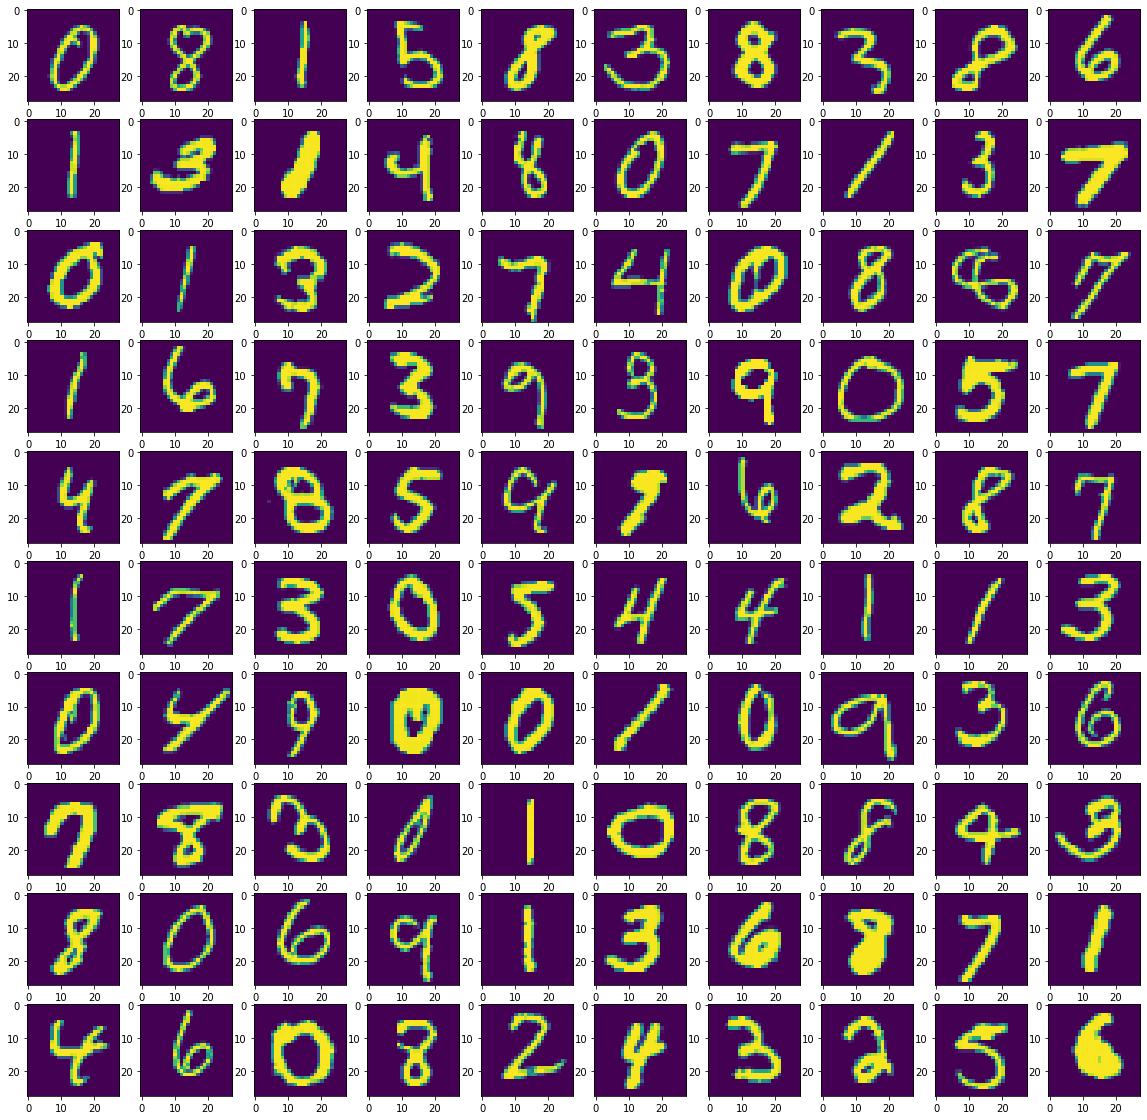

In [262]:
fig, axs = plt.subplots(len(j_int), len(j_int[0]),figsize=[20,20])
for i in range(len(j_int)):
    for j in range(len(j_int[i])):
        axs[i,j].imshow(x_train[j_int[i][j],:,:,0])

In [16]:
def illustrator(pos,layers,input_shape=28):
    for layer in layers:
        layer["input"] = input_shape
        if layer['padding'] == 'same':
            input_shape = int(np.ceil(input_shape/layer['stride']))
        else:
            input_shape = int(np.ceil((input_shape+1-layer['pool_size'])/layer['stride']))
    #print(input_shape)
    last_layer = np.zeros([input_shape,input_shape])
    left = pos[1]
    right = left+1
    top = pos[0]
    bottom = top+1
    last_layer[left:right,top:bottom] = 1
    layers.reverse()
    for layer in layers:
        current_layer = np.zeros([layer["input"],layer["input"]])
        left = max(0,layer["stride"]*left-int(layer['pool_size']/2))
        right = min(layer["input"],layer["stride"]*(right-1)+int(layer['pool_size']/2))+1
        top = max(0,layer["stride"]*top-int(layer['pool_size']/2))
        bottom = min(layer["input"],layer["stride"]*(bottom-1)+int(layer['pool_size']/2))+1
        #print(left,right, top, bottom)
        current_layer[left:right,left:right] = 1
    return left,right, top, bottom
        

In [18]:
layers = [
    {'padding': 'same' , 'pool_size': 5, 'stride': 1},
    {'padding': 'same' , 'pool_size': 5, 'stride': 1},
    {'padding': 'valid' , 'pool_size': 2, 'stride': 2},
    {'padding': 'same' , 'pool_size': 3, 'stride': 1},
    {'padding': 'same' , 'pool_size': 3, 'stride': 1},
    {'padding': 'valid' , 'pool_size': 2, 'stride': 2}
]

In [226]:
illustrator([1,1],layers,input_shape=28)

7
1 4 1 4
0 5 0 5
0 6 0 6
0 12 0 12
0 14 0 14
0 16 0 16


(0, 16, 0, 16)

# Count concepts

In [6]:
experiment_run = '2'
seed = int(experiment_run)
base_architecture = 'new_MNIST_base'
model_dir = './saved_models/' + base_architecture + '/' + experiment_run + '/'
a = pickle.load( open(model_dir+"a_{}.pkl".format(seed),"rb"))
b = pickle.load( open(model_dir+"b_{}.pkl".format(seed),"rb"))
j_int = pickle.load(open(model_dir+"j_int_{}.pkl".format(seed),"rb"))

In [8]:
all_neighbours = []
for seed in range(4000):
    experiment_run = str(seed)
    model_dir = './saved_models/' + base_architecture + '/' + experiment_run + '/'
    a = pickle.load( open(model_dir+"a_{}.pkl".format(seed),"rb"))
    b = pickle.load( open(model_dir+"b_{}.pkl".format(seed),"rb"))
    np.random.seed(seed)
    indices = np.random.choice(60000, size=int(0.7*60000), replace=False)
    j_int = pickle.load(open(model_dir+"j_int_{}.pkl".format(seed),"rb"))
    for key in a.keys():
        all_neighbours.append(np.asarray(indices[j_int[key]])*100+np.asarray(a[key])*10+np.asarray(b[key]))

In [9]:
all_neighbours = np.asarray(all_neighbours)

In [10]:
unique, counts = np.unique(all_neighbours, return_counts=True)

In [11]:
len(unique)

352831

(array([3.12361e+05, 3.50210e+04, 4.53100e+03, 7.22000e+02, 0.00000e+00,
        1.39000e+02, 3.00000e+01, 1.10000e+01, 3.00000e+00, 0.00000e+00,
        5.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ,
         9.8, 10.6, 11.4, 12.2, 13. , 13.8, 14.6, 15.4, 16.2, 17. ]),
 <a list of 20 Patch objects>)

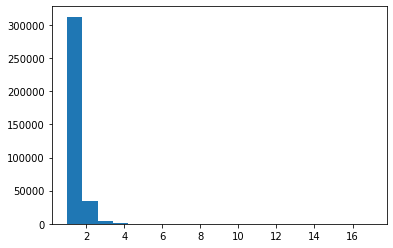

In [13]:
plt.hist(counts, bins=20)

In [14]:
unique[np.argmax(counts)]

4283300

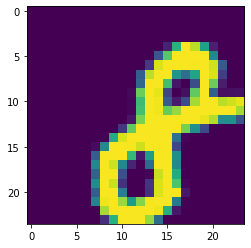

In [21]:
left,right, top, bottom = illustrator([0,0],layers,input_shape=28)
plt.imshow(x_train[42833,top:bottom,left:right,0])

In [22]:
sets = {}
set_numbers = {}
for number in unique:
    set_numbers[number] = -1
counter = 0

In [23]:
for new_set in all_neighbours:
    exisiting_sets = np.unique([set_numbers[member] for member in new_set])
    new_set_number = -1
    found = False
    for exisiting_set in exisiting_sets:
        if exisiting_set!=-1:
            if not found:
                new_set_number = exisiting_set
                found = True
            else:
                for member in sets[exisiting_set]:
                    set_numbers[member] = new_set_number
                    sets[new_set_number].add(member)
                sets.pop(exisiting_set,None)
    if new_set_number == -1:
        new_set_number = counter
        sets[new_set_number] = set()
        counter += 1
    for member in new_set:
        set_numbers[member] = new_set_number
        sets[new_set_number].add(member)     

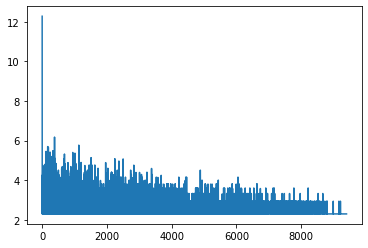

In [28]:
plt.plot(np.log([len(sets[key]) for key in sets.keys()]))

In [335]:
np.min(all_neighbours)

0

In [167]:
%%time
threshold = 0.7
all_concepts = []
for seed in range(0,100):
    print(seed,end=", ")
    experiment_run = str(seed)
    model_dir = './saved_models/' + base_architecture + '/' + experiment_run + '/'
    topic_prob = pickle.load( open(model_dir+"topic_prob_{}.pkl".format(seed),"rb"))
    sets = []
    for concept_number in range(10):
        sets.append(set())
    for ind, i , j, concept_number in zip(*np.where((topic_prob > threshold))):
        sets[concept_number].add(100*ind+10*i+j)
    all_concepts = all_concepts + sets

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, CPU times: user 1min 1s, sys: 3.58 s, total: 1min 4s
Wall time: 1min 4s


In [171]:
np.argmin([len(i) for i in all_concepts])

234

In [172]:
def intersection_over_union(s1,s2):
    if len(s1)==0 and len(s2)==0:
        return 0
    return len(s1.intersection(s2))/len(s1.union(s2))

In [173]:
similarity = np.zeros([1000,1000])

In [176]:
%%time
for i in range(0,1000):
    print(i,end=", ")
    for j in range(i+1,1000):
        similarity[i,j] = intersection_over_union(all_concepts[i],all_concepts[j])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

In [2]:
first_line = similarity[3]
first_line= np.sort(first_line)
plt.plot(first_line)

NameError: name 'similarity' is not defined

(array([9.8029e+05, 6.2730e+03, 3.7400e+03, 2.6310e+03, 1.8910e+03,
        1.4180e+03, 1.0680e+03, 8.1100e+02, 5.9200e+02, 4.4800e+02,
        3.2000e+02, 2.2000e+02, 1.3500e+02, 6.4000e+01, 4.9000e+01,
        3.1000e+01, 1.0000e+01, 6.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([0.        , 0.03873346, 0.07746691, 0.11620037, 0.15493382,
        0.19366728, 0.23240073, 0.27113419, 0.30986764, 0.3486011 ,
        0.38733455, 0.42606801, 0.46480146, 0.50353492, 0.54226837,
        0.58100183, 0.61973528, 0.65846874, 0.69720219, 0.73593565,
        0.7746691 ]),
 <a list of 20 Patch objects>)

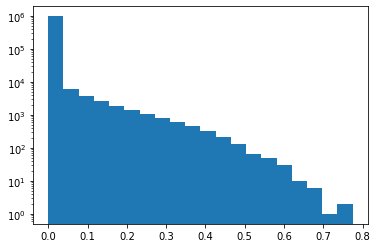

In [182]:
plt.hist(similarity.flatten(),log=True,bins=20)

In [218]:
from scipy.cluster import hierarchy

/opt/anaconda/envs/tf2/lib/python3.6/site-packages/ipykernel/__main__.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


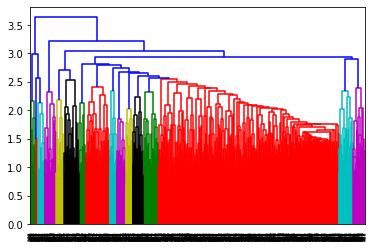

In [229]:
Z = hierarchy.linkage(distance_matrix, 'complete')

plt.figure()

dn = hierarchy.dendrogram(Z)

In [202]:
distance_matrix = similarity

In [203]:
distance_matrix = distance_matrix + distance_matrix.T

In [204]:
distance_matrix = distance_matrix + np.eye(len(distance_matrix))

In [205]:
distance_matrix = 1 - distance_matrix

In [87]:
random_sims = []
trials = 1000
for _ in range(trials):
    i = np.random.randint(1000)
    j = np.random.randint(1000)
    sim = intersection_over_union(all_concepts[i],all_concepts[j])
    random_sims.append([i,j,sim])

In [83]:
np.random.randint(1000)

950

In [105]:
random_sim_sort = np.argsort(np.asarray(random_sims)[:,2])

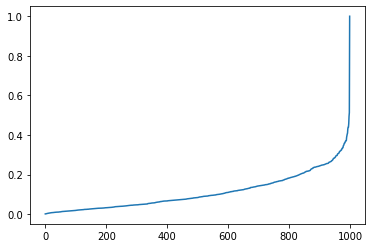

In [110]:
plt.plot(np.asarray(random_sims)[:,2][random_sim_sort])

In [97]:
random_sim_sort[-2]

0.5129879564136877

In [145]:
np.asarray(random_sims)[random_sim_sort[-10]]

array([9.5500000e+02, 5.8400000e+02, 3.9679707e-01])

In [121]:
e = next(iter(all_concepts[252]))

In [ ]:
int, 

4194304


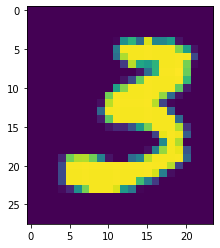

4


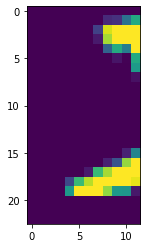

5


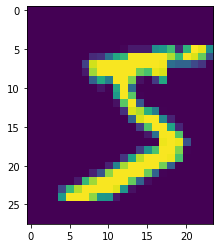

3145733


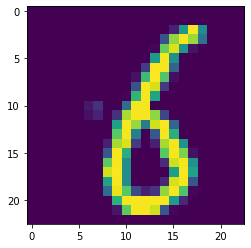

3670022


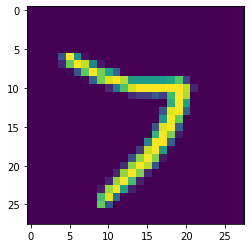

3670023


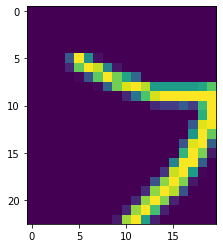

3670024


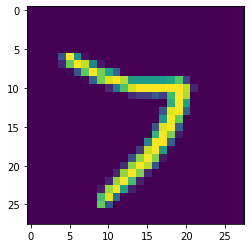

10


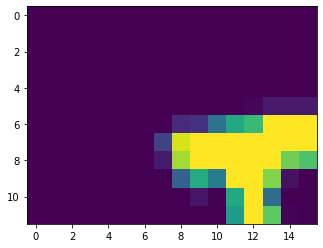

11


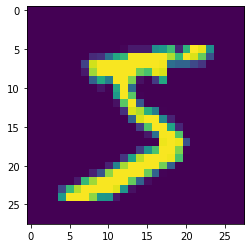

12


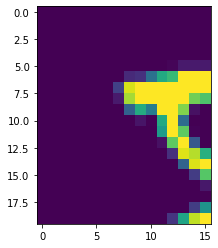

13


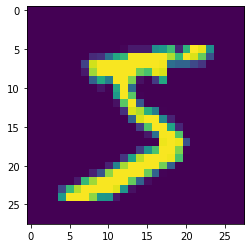

14


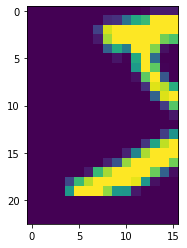

15


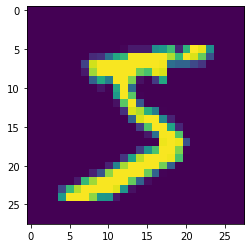

2621451


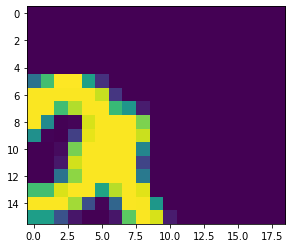

2621452


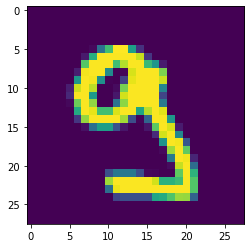

2621453


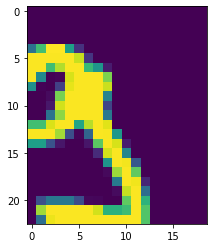

3670030


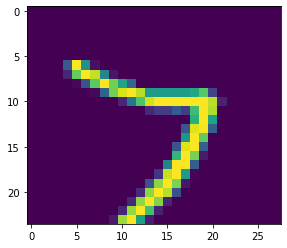

4194323


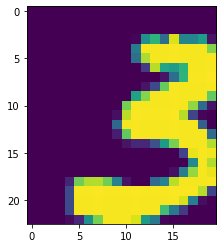

4718604


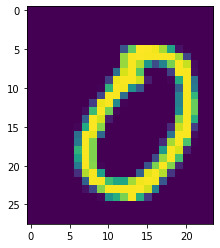

4718614


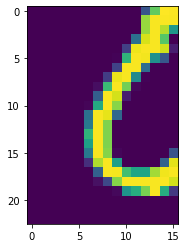

5242904


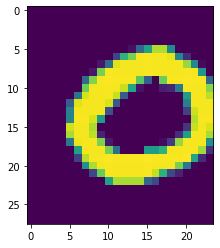

524313


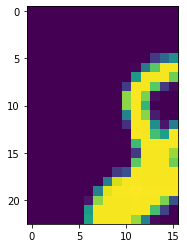

524314


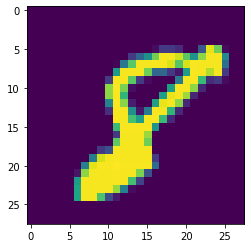

524315


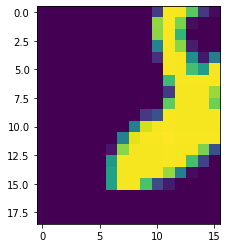

1048604


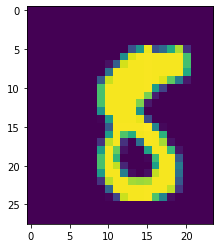

3145761


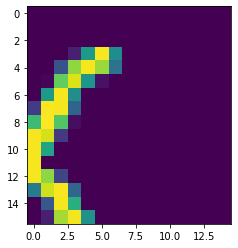

5242913


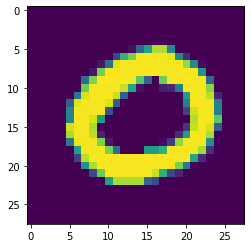

5242914


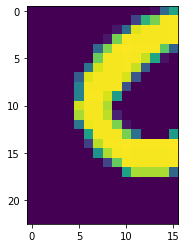

4194340


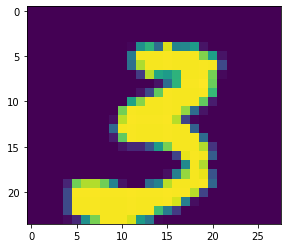

1048613


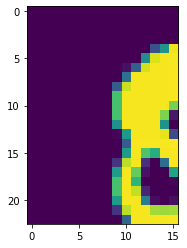

In [148]:
blaub = iter(all_concepts[584])
for i in range(30):
    e = next(blaub)
    print(e)
    left,right, top, bottom = illustrator([e%10, int(e%100/10)],layers,input_shape=28)
    plt.imshow(x_train[int(e/100),top:bottom,left:right,0])
    plt.show()

In [137]:
1+1

2